# 搜索最佳的回归模型
不必每次都提交，先在本地找到最佳模型、最佳特征
http://www.dataivy.cn/blog/regression_with_sklearn/

In [14]:
# 导入必要的工具包
import time
import numpy as np 
import pandas as pd 

from sklearn import tree
from sklearn import neighbors
from sklearn import ensemble

from sklearn.linear_model import BayesianRidge, Lasso, Ridge, ElasticNet, Lars, LassoLars, OrthogonalMatchingPursuit
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 
import seaborn as sns 
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.4f' % x)
%matplotlib inline

In [2]:
Y_Standard = True
# 生成的结果文件编号
out_name = '%ssummit=0.1-fe-%s.csv'

# path  = '../data/new/'
path_train = '../data/new/train=0.1/'
path_test = '../data/new/test/'
summit_path = '../data/summit/'

## 1 数据准备

In [3]:
train = pd.read_csv(path_train + 'train=0.1-fe.csv')
train.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,2320186,124,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.8333,0.0000,0,0.0000
1,2959017,121,129429,78242,0,0,6000,0,152480,48626,...,0,0,0,2,2,2,3.1667,0.0000,0,0.0000
2,242613,122,84839,52467,0,0,0,0,22144,29600,...,0,0,0,0,0,0,2.6667,0.0000,0,0.0000
3,1416097,136,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.3333,0.0000,0,0.0000
4,680469,104,28625,7200,0,0,0,0,33625,3930,...,0,0,0,0,0,0,1.0000,0.0000,0,0.0000


In [4]:
test = pd.read_csv(path_test + 'tap_fun_test-fe.csv')
test.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,sr_rss_help_bonus_level,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count
0,14933,94,166415.0000,138362.0000,0,0,0,0,258522,90142,...,0,0,0,0,1,1,1,8.0000,0.0000,0
1,14934,94,10000.0000,600.0000,0,0,0,0,10000,400,...,0,0,0,0,0,0,0,0.1667,0.0000,0
2,14935,94,10000.0000,3700.0000,0,0,0,0,10000,2000,...,0,0,0,0,0,0,0,17.0000,0.0000,0
3,14936,94,210000.0000,0.0000,200000,0,200000,0,610000,0,...,0,0,0,0,0,0,0,1.6667,0.0000,0
4,14937,94,11500.0000,3700.0000,0,0,0,0,11000,2000,...,0,0,0,0,0,0,0,0.3333,0.0000,0


In [5]:
# 从原始数据中分离输入特征x和输出y
target = 'prediction_pay_price'
id = 'user_id'
train_y = train[target].values
train_X = train.drop([target, id], axis = 1)

# test_id = test[id]
test_X = test.drop([id], axis = 1)

In [6]:
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(train_X, train_y, random_state=33, test_size=1)
print('train.shape=%s X_train_part.shape=%s X_test_part.shape=%s'
      %(train.shape, X_train_part.shape, X_val_part.shape))

train.shape=(228800, 109) X_train_part.shape=(228799, 107) X_test_part.shape=(1, 107)


## 2 数据标准化

In [7]:
# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train_part = ss_X.fit_transform(X_train_part)
X_val_part= ss_X.transform(X_val_part)
test_X = ss_X.transform(test_X)

if Y_Standard:
    y_train_part = ss_y.fit_transform(y_train_part.reshape(-1, 1))
    y_val_part = ss_y.transform(y_val_part.reshape(-1, 1))

In [8]:
# 标准化数据还原 
def inverse_StandardScaler(predict):
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

#输出预测后的数据
def generate_summit(predict):
    testPredict = test.copy()
    testPredict[target] = predict
    testPredict = testPredict[[id,target]]
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

## 3. 训练模型-1

In [24]:
# 需要转换为一维数组 
y_train_part_1d = y_train_part.reshape(y_train_part.shape[0])

def fit_models(model_dic, model_names, n_folds=5):
    '''
    n_folds: 交叉检验的次数
    '''
    cv_score_list = []  # 交叉检验结果列表
    pre_y_list = []  # 各个回归模型预测的y值列表
    print('model num=%s' % (len(model_dic)))
    
    for i, model in enumerate(model_dic):  # 读出每个回归模型对象
        ticks = time.time()
        scores = cross_val_score(model, X_train_part, y_train_part_1d, cv=n_folds)  # 将每个模型导入交叉检验模型中做训练检验
        cv_score_list.append(scores)  # 将交叉检验结果存入结果列表
        pre_y_list.append(model.fit(X_train_part, y_train_part_1d).predict(X_train_part))  # 将回归训练中得到的预测y存入列表
        ticks = time.time() - ticks
        print('%s model=%s time=%ss' % (i, model_names[i], ticks))
    
    return cv_score_list, pre_y_list

In [9]:
%%time

model_br = BayesianRidge()  # 建立贝叶斯岭回归模型对象
model_lasso = Lasso()  # 建立 lasso 回归模型对象
model_etc = ElasticNet()  # 建立弹性网络回归模型对象
# model_svr = LinearSVR()  # 建立支持向量机回归模型对象: SVR 类算法最慢, 效果并不好 
model_gbr = GradientBoostingRegressor()  # 建立梯度增强回归模型对象

model_names = ['BayesianRidge', 'Lasso', 'ElasticNet', 'GBR']  # 不同模型的名称列表
model_dic = [model_br, model_lasso, model_etc, model_gbr]  # 不同回归模型对象的集合
# cv_score_list, pre_y_list = fit_models(model_dic, model_names)
# Wall time: 25min 8s

0 model=BayesianRidge
1 model=Lasso
2 model=SVR
3 model=GBR
Wall time: 25min 8s


## 4 模型效果指标评估-1

In [10]:
n_samples, n_features = X_train_part.shape  # 总样本量,总特征数
model_metrics_name = [explained_variance_score, mean_absolute_error, mean_squared_error, r2_score]  # 回归评估指标对象集

In [10]:
for i in range(len(model_dic)):  # 循环每个模型索引
    tmp_list = []  # 每个内循环的临时结果列表
    for m in model_metrics_name:  # 循环每个指标对象
        tmp_score = m(y_train_part_1d, pre_y_list[i])  # 计算每个回归指标结果
        tmp_list.append(tmp_score)  # 将结果存入每个内循环的临时结果列表
    model_metrics_list.append(tmp_list)  # 将结果存入回归评估指标列表

df1 = pd.DataFrame(cv_score_list, index=model_names)  # 建立交叉检验的数据框
df2 = pd.DataFrame(model_metrics_list, index=model_names, columns=['ev', 'mae', 'mse', 'r2'])  # 建立回归指标的数据框

print ('samples: %d \t features: %d' % (n_samples, n_features))  # 打印输出样本量和特征数量
print (70 * '-')  # 打印分隔线
print ('cross validation result:')  # 打印输出标题
print (df1)  # 打印输出交叉检验的数据框
print (70 * '-')  # 打印分隔线
print ('regression metrics:')  # 打印输出标题
print (df2)  # 打印输出回归指标的数据框
print (70 * '-')  # 打印分隔线
print ('short name \t full name')  # 打印输出缩写和全名标题
print ('ev \t explained_variance')
print ('mae \t mean_absolute_error')
print ('mse \t mean_squared_error')
print ('r2 \t r2')
print (70 * '-')  # 打印分隔线
# 指标中r2跟ev的值是相同的，原因是r2作为判定系数，本身就是解释方差的比例，含义相同。

samples: 228799 	 features: 107
----------------------------------------------------------------------
cross validation result:
                    0       1       2       3       4
BayesianRidge -5.4702  0.4061  0.2683  0.1915 -0.5814
Lasso         -0.0000 -0.0000 -0.0000 -0.0000 -0.0001
SVR            0.1089  0.0540  0.4578  0.4730 -0.9986
GBR            0.7482  0.4976  0.5660  0.4374  0.3054
----------------------------------------------------------------------
regression metrics:
                  ev    mae    mse     r2
BayesianRidge 0.7566 0.0397 0.2434 0.7566
Lasso         0.0000 0.0470 1.0000 0.0000
SVR           0.6685 0.0189 0.3315 0.6685
GBR           0.9352 0.0121 0.0648 0.9352
----------------------------------------------------------------------
short name 	 full name
ev 	 explained_variance
mae 	 mean_absolute_error
mse 	 mean_squared_error
r2 	 r2
----------------------------------------------------------------------


## 5 模型效果可视化-1

In [48]:
color_list = ['r', 'm', 'g', 'y', 'c', 'b', 'r', 'm', 'g', 'y', 'c', 'b']  # 颜色列表
linestyle_list = ['-', '--', '-.', ':', '-', '--', '-.', ':','-', '--', '-.', ':']  # 样式列表

def plot_result(X, y, i):
    ''' 绘制原始值的曲线和预测值的曲线 '''
    plt.figure(figsize=(16, 6), clear=True)  # 创建画布
    plt.plot(np.arange(X.shape[0]), y, color='k', label='true y')  # 画出原始值的曲线
    # 画出每条预测结果线
    plt.plot(np.arange(X.shape[0]), pre_y_list[i], c=color_list[i], ls=linestyle_list[i], label=model_names[i])
    plt.title('regression result comparison: %s' % model_names[i])  # 标题
    plt.legend(loc='upper right')  # 图例位置
    plt.ylabel('real and predicted value')  # y轴标题
    plt.show()  # 展示图像

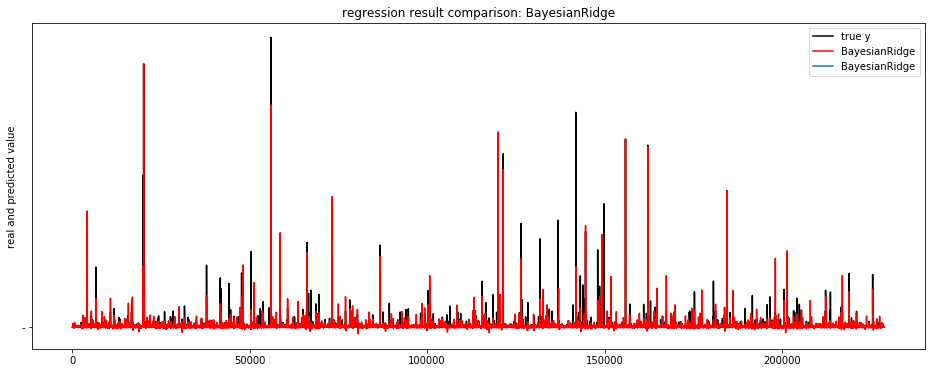

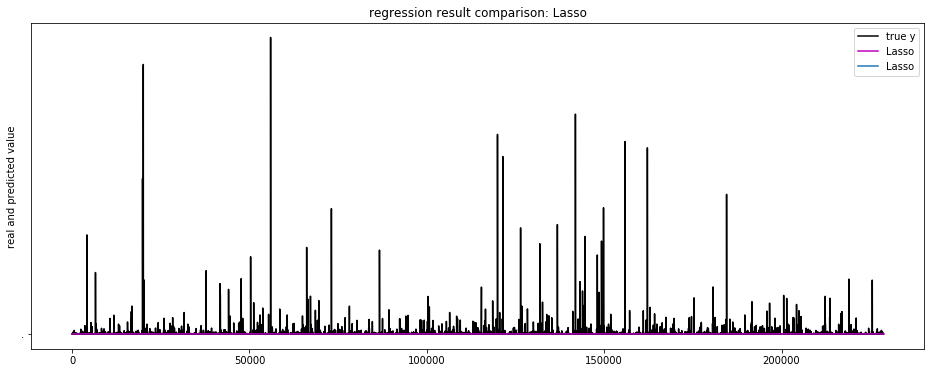

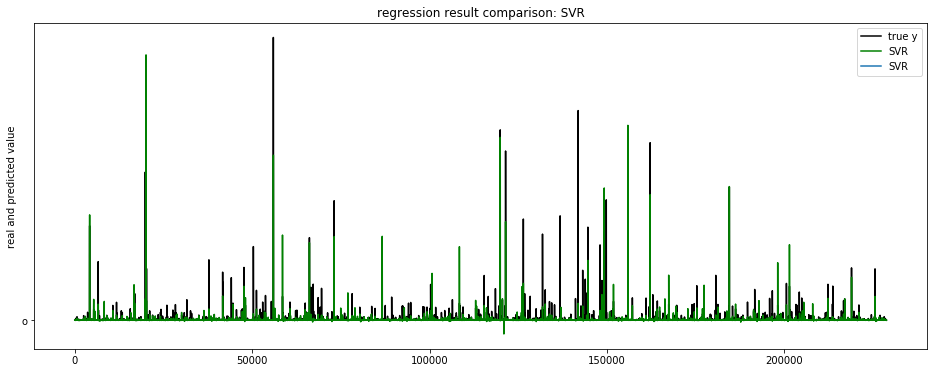

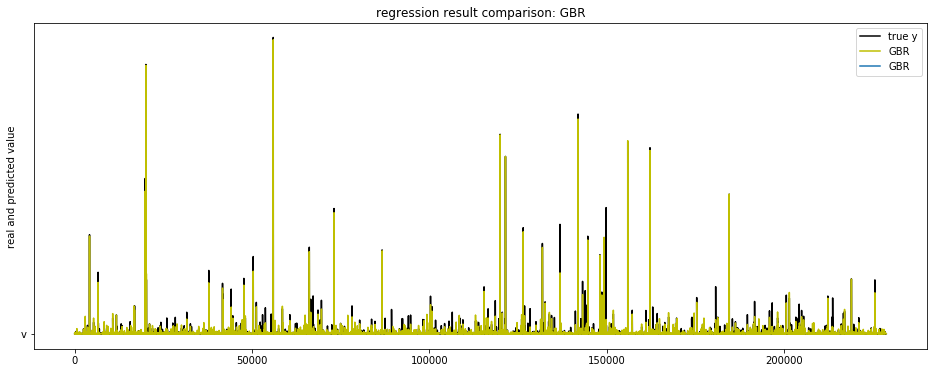

In [30]:
for i in range(len(model_dic)): 
    plot_result(X_train_part, y_train_part_1d, i)

## 6 模型应用: 最佳模型进行预测-1

In [ ]:
best_id = 1 # Lasso
best_id = 3 # GradientBoostingRegressor

best_model = model_dic[best_id]
best_name = model_names[best_id]
best_model

In [33]:
%%time
#对测试数据进行预测
gbr_predict_test = best_model.predict(test_X)
print('gbr_predict_test = ', gbr_predict_test)

# 标准化数据还原 
gbr_predict_test = inverse_StandardScaler(gbr_predict_test)

gbr_predict_test =  [-0.02239593 -0.02239593 -0.02239593 ... -0.02239593 -0.02239593
 -0.02239593]
predict =  [0.10311778 0.10311778 0.10311778 ... 0.10311778 0.10311778 0.10311778]
Wall time: 2.59 s


In [34]:
#输出预测后的数据
testPredict = generate_summit(gbr_predict_test)
testPredict.to_csv(out_name %(summit_path, best_name), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.1031
1,14934,0.1031
2,14935,0.1031
3,14936,0.1031
4,14937,0.1031


## 3. 训练模型-2

In [36]:
%%time
n_jobs = -1

model_DecisionTreeRegressor = tree.DecisionTreeRegressor()
model_ExtraTreeRegressor = tree.ExtraTreeRegressor()
# model_KNeighborsRegressor = neighbors.KNeighborsRegressor() #不适合高维数据，计算量太大

model_RandomForestRegressor = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=n_jobs) 
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(n_estimators=50) 
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(n_estimators=100) 
model_BaggingRegressor = ensemble.BaggingRegressor(n_estimators=20, n_jobs=n_jobs)
model_ExtraTreesRegressor = ensemble.ExtraTreesRegressor(n_estimators=20, n_jobs=n_jobs)

model_etc = ElasticNet(alpha=0.8)  # 建立弹性网络回归模型对象
# model_Lars = Lars() #适合高维数据
model_LassoLars = LassoLars() # LARS算法实现的lasso模型
model_OrthogonalMatchingPursuit = OrthogonalMatchingPursuit() #基于贪心算法实现

model_HuberRegressor = HuberRegressor() #能够处理数据中有异常值的情况
# model_KernelRidge = KernelRidge() #将核技巧应用到岭回归中，以实现非线性回归 ——内存报错
# model_GaussianProcessRegressor = GaussianProcessRegressor() #与KRR一样使用了核技巧 ——内存报错

# 不同模型的名称列表
model_names = ['DecisionTreeRegressor', 'ExtraTreeRegressor',
               'RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 
               'BaggingRegressor', 'ExtraTreesRegressor', 
               'ElasticNet', 'LassoLars', 'OrthogonalMatchingPursuit', 
               'HuberRegressor']  
# model_names = ['ElasticNet ', 'LassoLars']
# 不同回归模型对象的集合
model_dic = [model_DecisionTreeRegressor, model_ExtraTreeRegressor, 
             model_RandomForestRegressor, model_AdaBoostRegressor, model_GradientBoostingRegressor,
             model_BaggingRegressor, model_ExtraTreesRegressor,
             model_etc, model_LassoLars, model_OrthogonalMatchingPursuit,
             model_HuberRegressor] 
# model_dic = [model_etc, model_LassoLars]
cv_score_list, pre_y_list = fit_models(model_dic, model_names)
# Wall time: 25min 8s

model num=11
0 model=DecisionTreeRegressor time=86.55695080757141s
1 model=ExtraTreeRegressor time=52.88302493095398s
2 model=RandomForestRegressor time=337.9353287220001s
3 model=AdaBoostRegressor time=467.15371966362s
4 model=GradientBoostingRegressor time=665.3360550403595s
5 model=BaggingRegressor time=220.57961630821228s
6 model=ExtraTreesRegressor time=308.62665247917175s
7 model=ElasticNet time=9.712555408477783s
8 model=LassoLars time=4.337248086929321s
9 model=OrthogonalMatchingPursuit time=4.298245906829834s
10 model=HuberRegressor time=137.42986059188843s
Wall time: 38min 14s


## 4 模型效果指标评估-2

In [42]:
model_metrics_list = []  # 回归评估指标列表
for i in range(len(model_dic)):  # 循环每个模型索引
    tmp_list = []  # 每个内循环的临时结果列表
    for m in model_metrics_name:  # 循环每个指标对象
        tmp_score = m(y_train_part_1d, pre_y_list[i])  # 计算每个回归指标结果
        tmp_list.append(tmp_score)  # 将结果存入每个内循环的临时结果列表
    model_metrics_list.append(tmp_list)  # 将结果存入回归评估指标列表

df1 = pd.DataFrame(cv_score_list, index=model_names)  # 建立交叉检验的数据框
df2 = pd.DataFrame(model_metrics_list, index=model_names, columns=['ev', 'mae', 'mse', 'r2'])  # 建立回归指标的数据框

print ('samples: %d \t features: %d' % (n_samples, n_features))  # 打印输出样本量和特征数量
print (70 * '-')  # 打印分隔线
print ('cross validation result:')  # 打印输出标题
print (df1)  # 打印输出交叉检验的数据框
print (70 * '-')  # 打印分隔线
print ('regression metrics:')  # 打印输出标题
print (df2)  # 打印输出回归指标的数据框
print (70 * '-')  # 打印分隔线
print ('short name \t full name')  # 打印输出缩写和全名标题
print ('ev \t explained_variance')
print ('mae \t mean_absolute_error')
print ('mse \t mean_squared_error')
print ('r2 \t r2')
print (70 * '-')  # 打印分隔线
# 指标中r2跟ev的值是相同的，原因是r2作为判定系数，本身就是解释方差的比例，含义相同。

samples: 228799 	 features: 107
----------------------------------------------------------------------
cross validation result:
                                0       1       2       3       4
DecisionTreeRegressor      0.3454  0.1938 -0.1920  0.4276 -0.6699
ExtraTreeRegressor         0.5155  0.2541  0.2862  0.2706 -1.0168
RandomForestRegressor      0.7407  0.5279  0.6417  0.5015  0.2608
AdaBoostRegressor         -0.0512  0.0813  0.0347 -1.3970 -0.3232
GradientBoostingRegressor  0.7099  0.4978  0.5702  0.4669  0.2627
BaggingRegressor           0.6646  0.5096  0.5143  0.4849  0.3471
ExtraTreesRegressor        0.7439  0.4850  0.5703  0.5150  0.0693
ElasticNet                 0.4566  0.3148  0.4141  0.3078  0.7177
LassoLars                 -0.0000 -0.0000 -0.0000 -0.0000 -0.0001
OrthogonalMatchingPursuit -1.8849  0.3660  0.5392  0.1067  0.0982
HuberRegressor             0.6355  0.4142  0.6058  0.3977  0.6735
----------------------------------------------------------------------
regressio

## 5 模型效果可视化-2

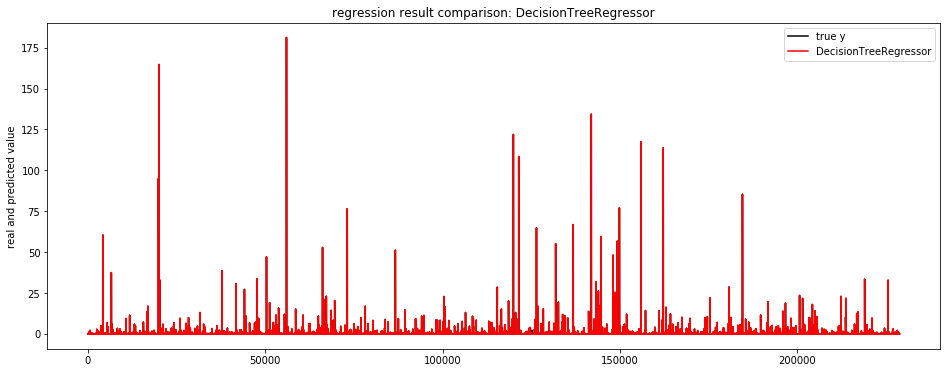

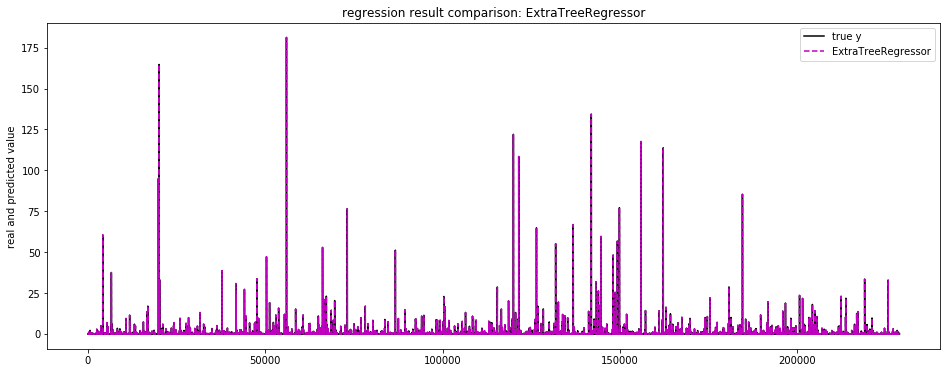

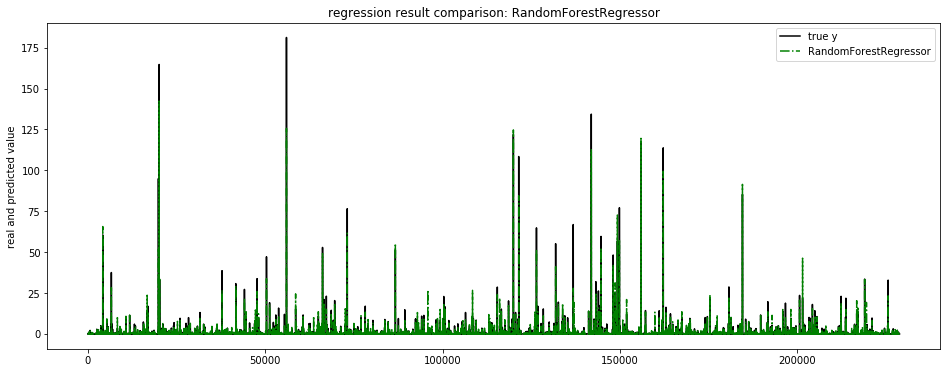

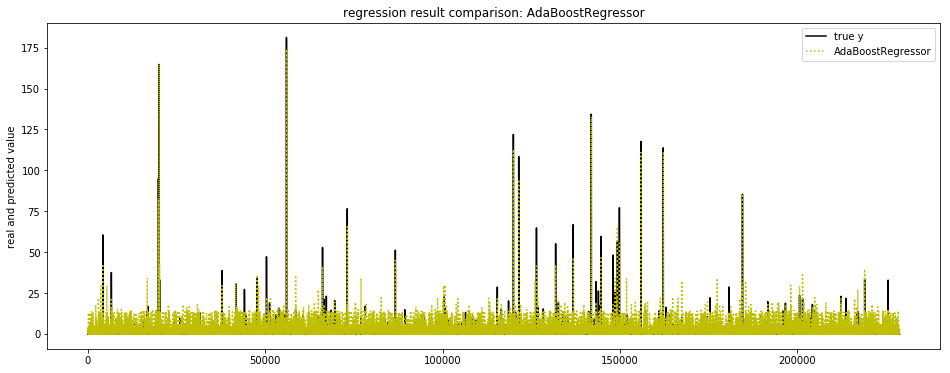

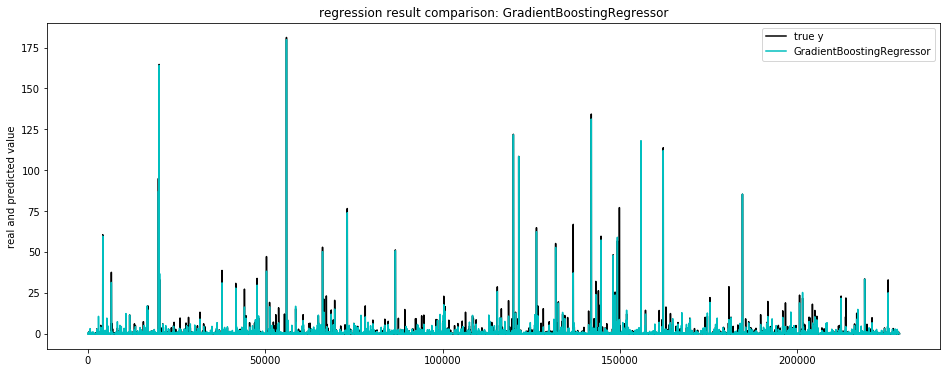

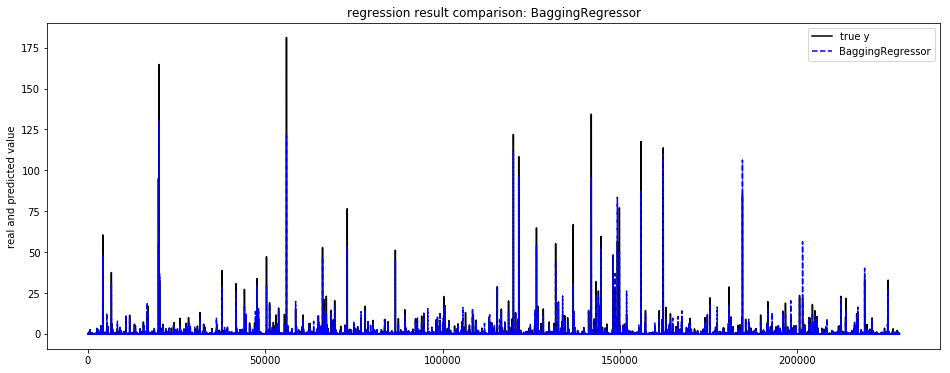

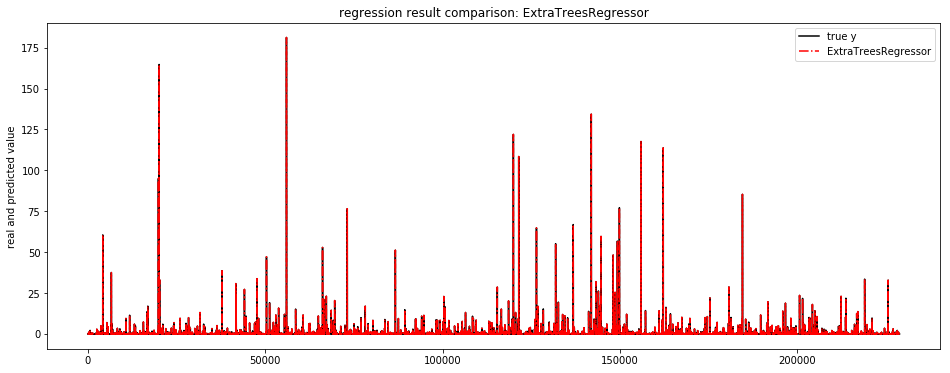

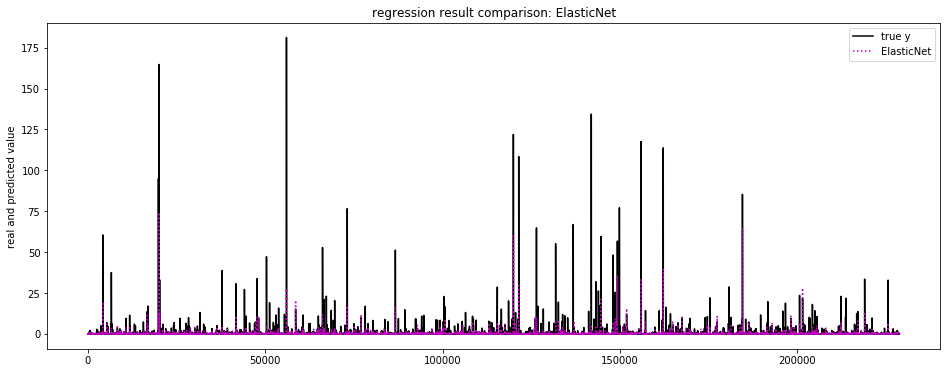

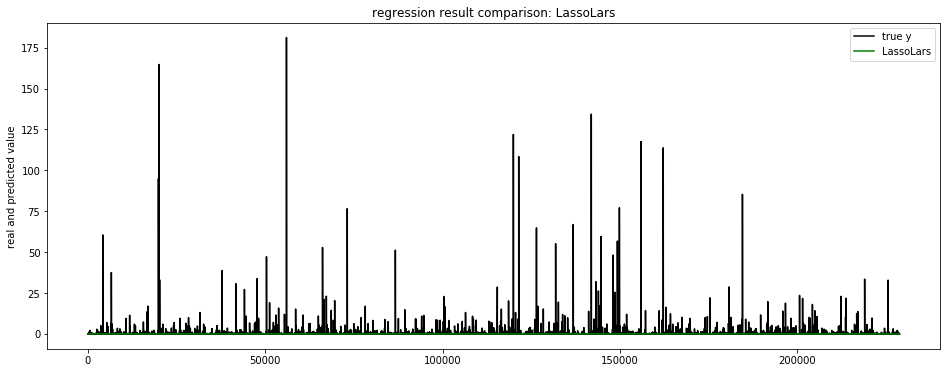

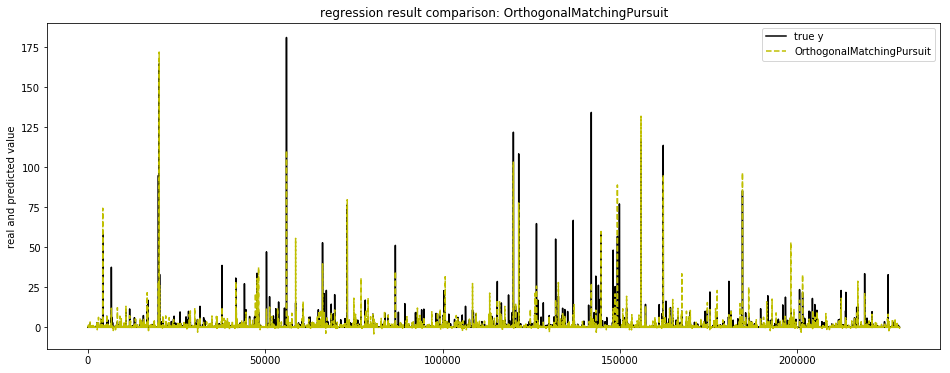

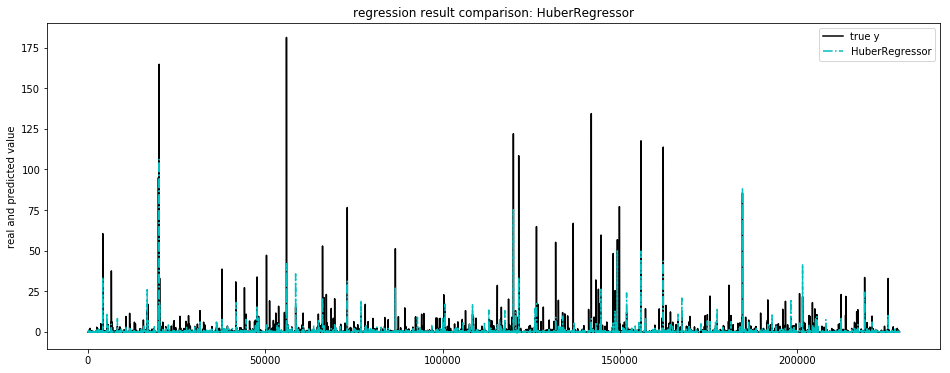

In [49]:
for i in range(len(model_dic)): 
    plot_result(X_train_part, y_train_part_1d, i)

## 6 模型应用: 最佳模型进行预测-2

In [62]:
best_id = 6 # ExtraTreesRegressor  
best_id = 8 # LassoLars  
best_id = 2 # RandomForestRegressor 
best_id = 5 # BaggingRegressor 
best_id = 10 # HuberRegressor  

best_model = model_dic[best_id]
best_name = model_names[best_id]
best_model

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [63]:
%%time
#对测试数据进行预测
gbr_predict_test = best_model.predict(test_X)
print('gbr_predict_test = ', gbr_predict_test)

# 标准化数据还原 
gbr_predict_test = inverse_StandardScaler(gbr_predict_test)

gbr_predict_test =  [-0.0237464  -0.02404846 -0.02421099 ... -0.02473346 -0.02397991
 -0.02401954]
predict =  [ 0.01282901 -0.007366   -0.01823201 ... -0.053163   -0.00278298
 -0.00543227]
Wall time: 197 ms


In [64]:
#输出预测后的数据
testPredict = generate_summit(gbr_predict_test)
testPredict.to_csv(out_name %(summit_path, best_name), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0128
1,14934,0.0000
2,14935,0.0000
3,14936,0.3300
4,14937,0.0000
